# Playing with the data, T5, etc and importing some stuffs

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/cnn_dailymail/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test.csv  train.csv  validation.csv


In [2]:
BASE_PATH = '/content/drive/MyDrive/cnn_dailymail/'

In [3]:
import torch
import torch.nn as nn
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import string
import sys
import pickle

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!pip install transformers
!pip install sentencepiece

In [5]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
train_data = pd.read_csv(BASE_PATH + "train.csv", nrows=100000)
test_data = pd.read_csv(BASE_PATH + "test.csv", nrows=100000)
val_data = pd.read_csv(BASE_PATH + "validation.csv", nrows=100000)

In [8]:
train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [9]:
train_data = train_data[['article', 'highlights']]
test_data = test_data[['article', 'highlights']]
val_data = val_data[['article', 'highlights']]

In [10]:
print('train articles without duplicates:', train_data['article'].nunique())
print('train highlights without duplicates:', train_data['highlights'].nunique())

print('test articles without duplicates:', test_data['article'].nunique())
print('test highlights without duplicates:', test_data['highlights'].nunique())

print('validation articles without duplicates:', val_data['article'].nunique())
print('validation highlights without duplicates:', val_data['highlights'].nunique())

train articles without duplicates: 99637
train highlights without duplicates: 99324
test articles without duplicates: 11488
test highlights without duplicates: 11449
validation articles without duplicates: 13368
validation highlights without duplicates: 13300


In [11]:
train_data.drop_duplicates(subset=['article'], inplace=True)
print("articles:", len(train_data))
train_data.drop_duplicates(subset=['highlights'], inplace=True)
print("highlights:", len(train_data))

test_data.drop_duplicates(subset=['article'], inplace=True)
print("articles:", len(test_data))
test_data.drop_duplicates(subset=['highlights'], inplace=True)
print("highlights:", len(test_data))

val_data.drop_duplicates(subset=['article'], inplace=True)
print("articles:", len(val_data))
val_data.drop_duplicates(subset=['highlights'], inplace=True)
print("highlights:", len(val_data))

articles: 99637
highlights: 99323
articles: 11488
highlights: 11449
articles: 13368
highlights: 13300


In [12]:
train_data.shape, test_data.shape, val_data.shape

((99323, 2), (11449, 2), (13300, 2))

In [13]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [14]:
s = train_data.article[2]
s = s.lower()
print(s)
s = re.sub('"','', s)
s = ' '.join([contractions[t] if t in contractions else t for t in s.split(" ")])
s = re.sub(r"'s\b","",s)
s = re.sub("[^a-zA-Z]", " ", s)
s = s.strip()
s = ' '.join(s.split())
s = ' '.join(word for word in s.split() if not word in stop_words if len(word) > 1)
print(s)

tokenizer = T5Tokenizer.from_pretrained("t5-base")

source = tokenizer.encode(
            s, 
            truncation=True,
            return_tensors='pt'
        )

print(source)

a drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. craig eccleston-todd, 27, was driving home from a night at a pub when he received a text message. as he was reading or replying to it, he veered across the road while driving round a bend and smashed into rachel titley’s car coming the other way. craig eccleston-todd, 27 (left) was using his mobile phone when he crashed head-on into the car being driven by rachel titley, 28 (right). she died later from her injuries . the head-on crash took place in october 2013. mr eccleston-todd's car was barely recognisable (pictured) police said eccleston-todd had drunk at least three or four pints of beer before getting behind the wheel. he was found guilty of causing death by dangerous driving at portsmouth crown court yesterday. miss titley, a 28-year-old solicitor’s clerk from cowes, isle of wight, had also spent the evening with friends at a pub but had not drunk any alcohol

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

tensor([[18364,  2535,  4792,  1021,  2335,   819,  8420,  6450,  1156,   951,
         11796,    15,    26,  1296,   203,     3,  2935,    23,   122,     3,
            15,    75,  2482,  4411,    12,    26,    26,  2191,   234,   706,
         11943,  1204,  1499,  1569,  1183,  8776,    53,     3,   162,  3737,
           640,  1373,  2191,  1751, 17995,     3,     7, 23991,     3,    52,
             9,  8738,  2233,    63,   443,  1107,   194,     3,  2935,    23,
           122,     3,    15,    75,  2482,  4411,    12,    26,    26,   646,
           338,  1156,   951, 24679,   819,   443,  6737,     3,    52,     9,
          8738,  2233,    63,   269,  3977,   865,  5157,   819,  8420,   808,
           286,     3,    32,    75,   235,  1152,     3,    51,    52,     3,
            15,    75,  2482,  4411,    12,    26,    26,   443, 11289,  5026,
         12905,     7,   179,     3, 22665,  2095,   243,     3,    15,    75,
          2482,  4411,    12,    26,    26, 18364,  

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
t  = Tokenizer()
fit_text = ["The earth is an awesome place live"]
t.fit_on_texts(fit_text)

test_text1 = "The earth is an great place live"
test_text2 = "The is my program"
sequences = t.texts_to_sequences([test_text1, test_text2])

print('sequences : ',sequences,'\n')
print('word_index : ',t.word_index)

t5t = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")
source = t5t(fit_text, return_tensors='pt').input_ids
label = t5t(test_text1, return_tensors='pt').input_ids
print(source.shape)
print(label.shape)
output = model(input_ids=source, labels=label)

loss = output.loss
logits = output.logits

print(loss)
print(logits.shape)

t1 = "summarize: Apple was founded in 1976 by Steve Jobs, Steve Wozniak and Ronald Wayne to develop and sell Wozniak's Apple I personal computer. It was incorporated by Jobs and Wozniak as Apple Computer, Inc. in 1977, and sales of its computers, among them the Apple II, grew quickly. It went public in 1980, to instant financial success. Over the next few years, Apple shipped new computers featuring innovative graphical user interfaces, such as the original Macintosh, announced in a critically acclaimed advertisement, 1984, directed by Ridley Scott. The high cost of its products and limited application library caused problems, as did power struggles between executives. In 1985, Wozniak departed Apple amicably,[15] while Jobs resigned to found NeXT, taking some Apple employees with him"
sources = t5t(t1, return_tensors='pt').input_ids

outputs = model.generate(sources)
print(tokenizer.decode(outputs[0] , skip_special_tokens=True))

sequences :  [[1, 2, 3, 4, 6, 7], [1, 3]] 

word_index :  {'the': 1, 'earth': 2, 'is': 3, 'an': 4, 'awesome': 5, 'place': 6, 'live': 7}


Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

torch.Size([1, 8])
torch.Size([1, 8])
tensor(3.9891, grad_fn=<NllLossBackward0>)
torch.Size([1, 8, 32128])
apple was founded in 1976 by Steve Jobs, Steve Wozniak and Ronald Wayne


min article length : 18
max article length : 2226
avg article length : 691.5873966754931
min highlight length : 4
max highlight length : 1296
avg highlight length : 51.57164000281909


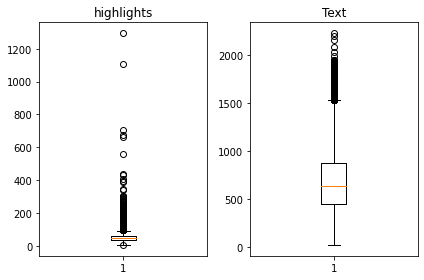

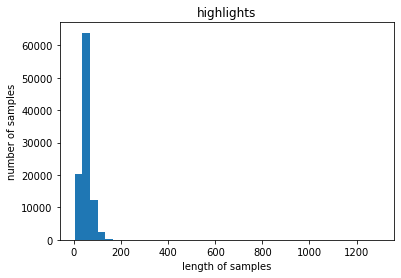

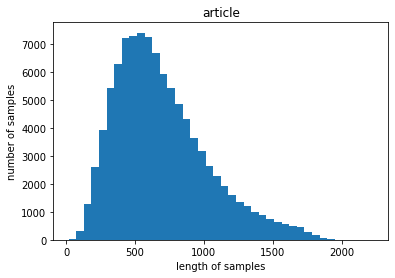

In [17]:
text_len = [len(s.split()) for s in train_data['article']]
summary_len = [len(s.split()) for s in train_data['highlights']]

print('min article length : {}'.format(np.min(text_len)))
print('max article length : {}'.format(np.max(text_len)))
print('avg article length : {}'.format(np.mean(text_len)))
print('min highlight length : {}'.format(np.min(summary_len)))
print('max highlight length : {}'.format(np.max(summary_len)))
print('avg highlight length : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('highlights')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('highlights')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('article')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
train_data = train_data.sample(n = 500)
test_data = test_data.sample(n = 250)
val_data = val_data.sample(n = 200)

# Preprocessing the data

In [19]:
ARTICLE_LENGTH = 512 
HIGHLIGHTS_LENGTH = 128

In [20]:
def preprocess_helper(sentence):
    sentence = sentence.lower()
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = sentence.strip()
    sentence = ' '.join(sentence.split())
    sentence = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)

    return sentence

In [21]:
class ArticleDataset(Dataset):

  def __init__(self, df, tokenizer):
    self.df = df
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    article_sentence = self.df.iloc[index][0]
    highlight_sentence = self.df.iloc[index][1]

    clean_article_sentence = preprocess_helper(article_sentence)
    clean_highlight_sentence = preprocess_helper(highlight_sentence)
    
    input_ids = self.tokenizer(clean_article_sentence, truncation=True, max_length=ARTICLE_LENGTH, padding='max_length', return_tensors='pt').input_ids
    labels = self.tokenizer(clean_highlight_sentence, truncation=True, max_length=HIGHLIGHTS_LENGTH, padding='max_length', return_tensors='pt').input_ids

    return input_ids[0], labels[0]


In [22]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

train_article_set = ArticleDataset(train_data, tokenizer)
test_article_set = ArticleDataset(test_data, tokenizer)
val_article_set = ArticleDataset(val_data, tokenizer)

print("Number of train articles: {}".format(len(train_article_set)))
print("Number of test articles: {}".format(len(test_article_set)))
print("Number of validation articles: {}".format(len(val_article_set)))
print()

Number of train articles: 500
Number of test articles: 250
Number of validation articles: 200



In [23]:
def do_collate(batch):
  inputs, labels = zip(*batch)
  return torch.stack(inputs), torch.stack(labels)

In [24]:
BATCH_SIZE = 2
SHUFFLE = True
NUM_WORKERS = 0

train_data_loader = DataLoader(train_article_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, collate_fn=do_collate, num_workers=NUM_WORKERS, drop_last=True)
test_data_loader = DataLoader(test_article_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, collate_fn=do_collate, num_workers=NUM_WORKERS, drop_last=True)
val_data_loader = DataLoader(val_article_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, collate_fn=do_collate, num_workers=NUM_WORKERS, drop_last=True)

ids, labels = iter(train_data_loader).next()

# Train function

In [25]:
EPOCH = 10
ACCUM_ITER = 8
LEARNING_RATE = 0.001
PRINT_EVERY = 10
VERBOSE = 1

In [26]:
def train(model, loader, epoch=EPOCH, lr=LEARNING_RATE, print_every=PRINT_EVERY, verbose=VERBOSE):
  model.to(device)
  model.train()
  losses = []
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  for epoch in range(EPOCH):

    # print('epoch : ' + str(epoch))

    sum = 0.0
    losses_epoch = []
    print(model.device)

    for index, batch in enumerate(loader):

      # shape of input_ids is [32, 1, 1500]?
      # shape of labels is [32, 1, 150]?
      # GRADIENT ACCUMULATION
      # print(batch[0].shape)
      input_ids, labels = batch[0], batch[1]
      input_ids = input_ids.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()

      # print('hi')
      outputs = model(input_ids=input_ids, labels=labels)
      loss = outputs.loss
      loss = loss / ACCUM_ITER
      loss.backward()
      
      if ((index + 1) % ACCUM_ITER == 0) or (index + 1 == len(loader)):
        optimizer.step()
        optimizer.zero_grad()

      losses_epoch.append(loss.item())
      sum += loss.item()
      if index % print_every == print_every - 1:
        if verbose:
          print("Train Epoch: %5d, Batch: %5d, Loss: %.3f" % (epoch, index + 1, sum / print_every))
        sum = 0.0

    
    losses.append(np.array(losses_epoch).mean())
  
  return losses

# Predict Function

In [27]:
@torch.no_grad()
def predict(model, loader, epoch=EPOCH, print_every=PRINT_EVERY, verbose=VERBOSE):
    model.eval()
    accuracies = []

    for epoch in range(epoch):
        accuracies_epoch = []

        for i, batch in enumerate(loader):
            input_ids, labels = batch[0], batch[1]
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            prediction = model(input_ids=input_ids, labels=labels)
            is_correct = (prediction.loss > 0.5) == labels
            accuracy = is_correct.cpu().numpy().tolist()
            accuracies_epoch.extend(accuracy)

            if i % print_every == print_every - 1:
                if verbose:
                    print("Predict Epoch: %5d, Batch: %5d" % (epoch, i + 1))

        accuracies.append(np.mean(accuracies_epoch))
    return accuracies


# Validate function

In [28]:
@torch.no_grad()
def validate(model, loader, epoch=EPOCH, print_every=PRINT_EVERY, verbose=VERBOSE):
    model.eval()
    criterion = nn.BCELoss()
    val_losses = []
    val_accuracies = []

    for epoch in range(epoch):
        val_losses_epoch = []
        val_accuracies_epoch = []

        for i, batch in enumerate(loader):
            input_ids, labels = batch[0], batch[1]
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            prediction = model(input_ids=input_ids, labels=labels)
            is_correct = (prediction.loss > 0.5) == labels
            accuracy = is_correct.cpu().numpy().tolist()
            val_accuracies_epoch.extend(accuracy)
            val_losses_epoch.append(prediction.loss.item())

            if i % print_every == print_every - 1:
                if verbose:
                    print("Validate Epoch: %5d, Batch: %5d" % (epoch, i + 1))

        val_accuracies.append(np.mean(val_accuracies_epoch))
        val_losses.append(np.array(val_losses_epoch).mean())
    return val_losses, val_accuracies

# Model


In [29]:
def T5():
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    return model

model_T5 = T5()
print(model_T5)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

# Main function

In [30]:
# train gets stuck at epoch 0
# i think that's because its trying to train 1500?
# should i lower the max or is there something wrong with batching?
# lowered the max length to 512 and 256, still doesnt work
# lowered to like 10 and 5, still doesnt work. something must be wrong with train

train_losses = train(model_T5, train_data_loader)
train_accuracies = predict(model_T5, test_data_loader)
val_losses, val_accuracies = validate(model_T5, val_data_loader)

cuda:0
Train Epoch:     0, Batch:    10, Loss: 1.145
Train Epoch:     0, Batch:    20, Loss: 0.539
Train Epoch:     0, Batch:    30, Loss: 0.354
Train Epoch:     0, Batch:    40, Loss: 0.227
Train Epoch:     0, Batch:    50, Loss: 0.233
Train Epoch:     0, Batch:    60, Loss: 0.259
Train Epoch:     0, Batch:    70, Loss: 0.205
Train Epoch:     0, Batch:    80, Loss: 0.190
Train Epoch:     0, Batch:    90, Loss: 0.188
Train Epoch:     0, Batch:   100, Loss: 0.213
Train Epoch:     0, Batch:   110, Loss: 0.224
Train Epoch:     0, Batch:   120, Loss: 0.180
Train Epoch:     0, Batch:   130, Loss: 0.187
Train Epoch:     0, Batch:   140, Loss: 0.191
Train Epoch:     0, Batch:   150, Loss: 0.194
Train Epoch:     0, Batch:   160, Loss: 0.184
Train Epoch:     0, Batch:   170, Loss: 0.171
Train Epoch:     0, Batch:   180, Loss: 0.153
Train Epoch:     0, Batch:   190, Loss: 0.182
Train Epoch:     0, Batch:   200, Loss: 0.159
Train Epoch:     0, Batch:   210, Loss: 0.218
Train Epoch:     0, Batch: 

In [31]:
model_path = BASE_PATH + 't5_model_v1.pt'

In [32]:
torch.save(model_T5.state_dict(), model_path)

# Testing/Plotting

In [ ]:
my_model = T5()
my_model.load_state_dict(torch.load(model_path))
my_model.eval()

In [61]:
print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)

[0.24961031413078308, 0.15557134352624416, 0.1403471512570977, 0.13598840156197547, 0.13199535498023032, 0.12562097668647765, 0.1210233850479126, 0.11653567214310169, 0.11448899963498116, 0.10804644636064768]
[0.0078125, 0.0133125, 0.0078125, 0.0078125, 0.01853125, 0.012687500000000004, 0.0078125, 0.011968749999999998, 0.0078125, 0.019125]
[1.2939951395988465, 1.293995174765587, 1.293995171189308, 1.2939951625466346, 1.2939951881766318, 1.293995162844658, 1.2939951568841934, 1.2939951640367509, 1.2939951777458192, 1.293995162844658]
[0.0078125, 0.0078125, 0.0078125, 0.021171875, 0.0160546875, 0.0164453125, 0.0144140625, 0.01484375, 0.0230859375, 0.0148046875]


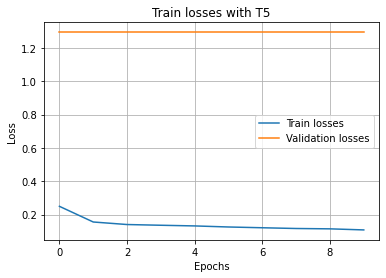

In [64]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline


plt.plot(train_losses, label='Train losses')
plt.plot(epochs, val_losses, label='Validation losses')
plt.title('Train and validation losses with T5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

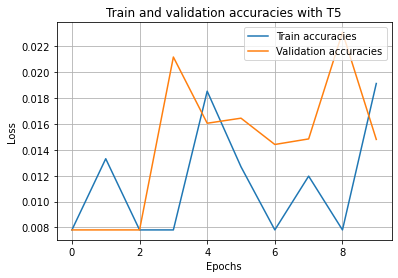

In [67]:
plt.plot(train_accuracies, label='Train accuracies')
plt.plot(epochs, val_accuracies, label='Validation accuracies')
plt.title('Train and validation accuracies with T5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [69]:
text = 'Law-enforcement agencies in South-East Asia have grown accustomed to breaking records. In almost every year between 2011 and 2020, the authorities seized more meth, as the drug is commonly known, than they had the year before. Between 2015 and 2019, the only other region to impound as much of the stuff as East and South-East Asia (which the un groups together) was North America—though the overall volume of drugs flowing through Asia is probably greater, because authorities there are more corrupt and less well-equipped to intercept traffickers, says Jeremy Douglas of the United Nations Office on Drugs and Crime (unodc), an un agency. And recorded seizures are likely to be just the tip of the iceberg.'
text = preprocess_helper(text)
source = tokenizer(text, return_tensors='pt').input_ids
outputs = my_model.generate(source)
print(tokenizer.decode(outputs[0] , skip_special_tokens=True))

asia grown accustomed breaking records almost every year authorities seized meth drug asia grown


In [70]:
text = 'Today Africans lead several global institutions. Tedros Adhanom Ghebreyesus, an Ethiopian, has steered the World Health Organisation (who) through the pandemic. Ngozi Okonjo-Iweala, a Nigerian, heads the World Trade Organisation (wto). Makh tar Diop, a Senegalese, presides over an investment portfolio worth about $64bn at the International Finance Corporation (ifc), the semi-independent arm of the World Bank that invests in private firms. A stitch-up gives the top jobs at the World Bank and imf to America and Europe. But for just the second time a sub-Saharan African, Antoinette Sayeh of Liberia, is a deputy managing director of the imf.'
text = preprocess_helper(text)
source = tokenizer(text, return_tensors='pt').input_ids
outputs = my_model.generate(source)
print(tokenizer.decode(outputs[0] , skip_special_tokens=True))

imf america europe second time sub saharan africans lead several


In [71]:
text = 'Irving is not eligible to play in home games at Barclays Center due to the vaccine mandate in New York City, and while he could be a part-time player, the team announced before the season that they would not allow him to be with them until he could be a full-time participant.  '
text = preprocess_helper(text)
source = tokenizer(text, return_tensors='pt').input_ids
outputs = my_model.generate(source)
print(tokenizer.decode(outputs[0] , skip_special_tokens=True))

barclays center due vaccine mandate new york city could part time player team announced season would allow
